In [12]:
import os
import mne
from mne_bids import BIDSPath

bids_root = os.path.join(mne.get_config('MNE_DATA'), 'derivatives', 'mne-bids-pipeline', 'STBF-ERP_CORE')
path = BIDSPath(root=bids_root, subject='002', task='P3', datatype='eeg', processing='clean', suffix='epo', check=False)
epochs = mne.read_epochs(path.match()[0])
epochs.metadata['label'] = epochs.metadata['event_name'].str.startswith('stimulus/target')

Reading /data/mne_data/derivatives/mne-bids-pipeline/STBF-ERP_CORE/sub-002/ses-P3/eeg/sub-002_ses-P3_task-P3_proc-clean_epo.fif ...
    Found the data of interest:
        t =    -203.12 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 28 columns
200 matching events found
No baseline correction applied
0 projection items activated


In [13]:
epochs.drop_channels(['P9', 'P10'])
epochs.decimate(2)
epochs.crop(tmin=0.1, tmax=0.6)
epochs.reorder_channels([
    'FP1', 'FP2',
    'F3', 'F7', 'Fz', 'F4', 'F8',
    'FC3', 'FCz', 'FC4',
    'C3', 'C5', 'Cz', 'C4', 'C6',
    'CPz',
    'P3', 'P7', 'Pz', 'P4', 'P8',
    'PO7', 'PO3', 'PO8', 'PO4',
    'O1', 'Oz', 'O2',
    'HEOG', 'VEOG',
])
epochs.pick_types(eeg=True, eog=True)

/tmp/ipykernel_68794/1285858729.py:2: RuntimeWarning: The measurement information indicates a low-pass frequency of 16 Hz. The decim=2 parameter will result in a sampling frequency of 32 Hz, which can cause aliasing artifacts.
  epochs.decimate(2)


Number of events,200
Events,stimulus/non-target/12: 8stimulus/non-target/13: 5stimulus/non-target/14: 8stimulus/non-target/15: 11stimulus/non-target/21: 5stimulus/non-target/23: 9stimulus/non-target/24: 7stimulus/non-target/25: 11stimulus/non-target/31: 4stimulus/non-target/32: 9stimulus/non-target/34: 9stimulus/non-target/35: 10stimulus/non-target/41: 11stimulus/non-target/42: 5stimulus/non-target/43: 4stimulus/non-target/45: 12stimulus/non-target/51: 16stimulus/non-target/52: 5stimulus/non-target/53: 7stimulus/non-target/54: 4stimulus/target/11: 8stimulus/target/22: 8stimulus/target/33: 8stimulus/target/44: 8stimulus/target/55: 8
Time range,0.094 – 0.594 sec
Baseline,off


In [14]:
X_train = epochs[:100].get_data()
y_train = epochs.metadata['label'][:100].values

X_test = epochs[100:].get_data()
y_test = epochs.metadata['label'][100:].values

In [15]:
from decode.classifier import UnitVarianceChannelScaler

scaler = UnitVarianceChannelScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
from decode.cov import KroneckerCovariance, ToeplitzCovariance
from decode.stbf import LCMVBeamformer
from sklearn.covariance import EmpiricalCovariance

cov_estimator = KroneckerCovariance(shrinkage=('oas', 'oas'), verbose=True, spatial=EmpiricalCovariance(), temporal=ToeplitzCovariance())
stbf = LCMVBeamformer(cov_estimator=cov_estimator)
stbf.fit(X_train, y_train)

Iteration 1  step: 465.25020001864056
Iteration 2  step: 237.58960544560486
Iteration 3  step: 218.48433063976694
Iteration 4  step: 90.67705126581878
Iteration 5  step: 75.0537428535115
Iteration 6  step: 35.83759688801077
Iteration 7  step: 27.000833450846912
Iteration 8  step: 14.432342625659622
Iteration 9  step: 10.210473400735955
Iteration 10  step: 5.8620744155682
Iteration 11  step: 3.9864833427271593
Iteration 12  step: 2.396072318349641
Iteration 13  step: 1.5895518907282824
Iteration 14  step: 0.9870721808319509
Iteration 15  step: 0.6449653394993319
Iteration 16  step: 0.4123333674232392
Iteration 17  step: 0.26748646683324256
Iteration 18  step: 0.17711111968151164
Iteration 19  step: 0.11517873957669533
Iteration 20  step: 0.080176654372478
Iteration 21  step: 0.05297246728070874
Iteration 22  step: 0.039384999759337055
Iteration 23  step: 0.026772200519882477
Iteration 24  step: 0.02125908274217484
Iteration 25  step: 0.014906695670344755
Iteration 26  step: 0.0123988759

LCMVBeamformer(cov_estimator=KroneckerCovariance(shrinkage=('oas', 'oas'),
                                                 spatial=EmpiricalCovariance(assume_centered=True),
                                                 temporal=ToeplitzCovariance(),
                                                 verbose=True))

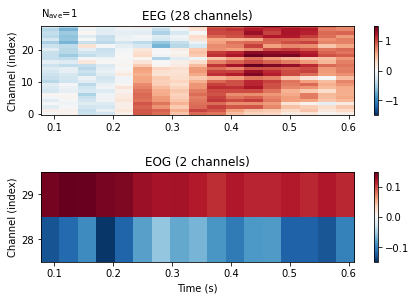

In [17]:
ap = mne.EvokedArray(stbf.lead_field_, epochs.info, epochs.tmin)
ap.plot_image(units=dict(eeg='', eog=''), scalings=dict(eeg=1, eog=1));

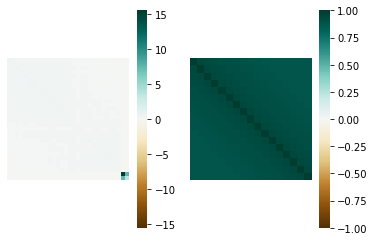

In [18]:
from util.viz import plot_cov
import seaborn as sns
import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 2)
plot_cov(stbf.cov_estimator_.spatial_.covariance_, ax=axs[0])
plot_cov(stbf.cov_estimator_.temporal_.covariance_, ax=axs[1]);

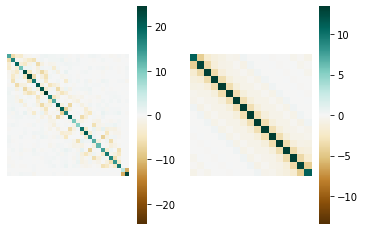

In [19]:
_, axs = plt.subplots(1, 2)
plot_cov(stbf.cov_estimator_.spatial_.precision_, ax=axs[0])
plot_cov(stbf.cov_estimator_.temporal_.precision_, ax=axs[1]);

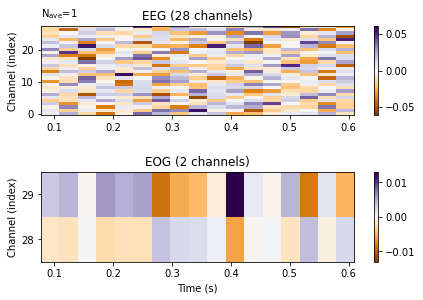

In [20]:
weights = mne.EvokedArray(stbf.weights_, epochs.info, epochs.tmin)
weights.plot_image(units=dict(eeg='', eog=''), scalings=dict(eeg=1, eog=1), cmap='PuOr');

<AxesSubplot:>

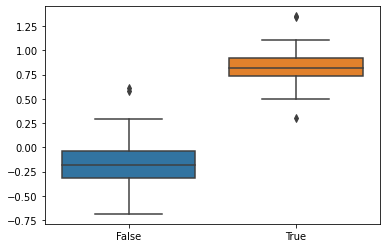

In [21]:
import seaborn as sns

scores_train = stbf.transform(X_train).squeeze()
sns.boxplot(x=y_train, y=scores_train)

<AxesSubplot:>

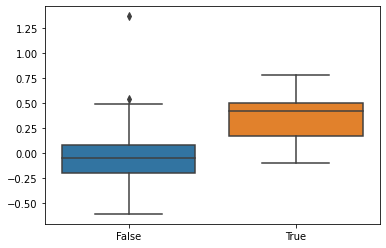

In [22]:
scores_test = stbf.transform(X_test).squeeze()
sns.boxplot(x=y_test, y=scores_test)